# Neural Network Model

import statements

In [766]:
import numpy as np
import pandas as pd
import torch
import json
from torch.utils.data import random_split, Dataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from torch.autograd import Variable

splitting the data

In [767]:
# Load JSON data
with open('restaurant-topic-sentiment.json') as file:
    json_data = json.load(file)

# Convert to DataFrame
df = pd.DataFrame.from_dict(json_data, orient='index')

# Shuffle the DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Convert DataFrame to numpy array
data = df.to_numpy()

# Calculate the size of train and test splits
train_size = int(0.8 * len(data))
test_size = len(data) - train_size

# Split the dataset
train_data, test_data = random_split(data, [train_size, test_size], generator=torch.Generator().manual_seed(42))

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Assuming the last column (index -1) is the label 'rating'
        x = self.data[idx, :-1]
        y = self.data[idx, -1]
        return x, y

# Create datasets and dataloaders
train_dataset = CustomDataset(np.array(train_data))
test_dataset = CustomDataset(np.array(test_data))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

define our hyperparameters

In [768]:
inputDim = 10
outputDim = 1
learningRate = .011
epochs = 130

lambda1 = 0 # l1 regularization parameter (sum of weights)
lambda2 = 0 # l2 regularization parameter (sum of square of weights)

defining different models

In [769]:
class NeuralNetwork1(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(NeuralNetwork1, self).__init__()
        self.relu = torch.nn.ReLU() 
        self.layer1 = torch.nn.Linear(inputSize, 10)  # Only hidden layer
        self.output_layer = torch.nn.Linear(10, outputSize)  # Output layer

    def forward(self, x):
        x = self.relu(self.layer1(x))  # Using ReLU activation function
        x = self.output_layer(x)
        return x


In [770]:
class NeuralNetwork2(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(NeuralNetwork2, self).__init__()
        self.relu = torch.nn.ReLU() # activation function
        self.layer1 = torch.nn.Linear(inputSize, 10)  # First hidden layer
        self.layer2 = torch.nn.Linear(10, 10)         # Second hidden layer
        self.output_layer = torch.nn.Linear(10, outputSize)  # Output layer

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.output_layer(x)
        return x

In [771]:
class NeuralNetwork3(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(NeuralNetwork3, self).__init__()
        self.relu = torch.nn.ReLU() 
        self.layer1 = torch.nn.Linear(inputSize, 50)  # First hidden layer
        self.layer2 = torch.nn.Linear(50, 50)         # Second hidden layer
        self.layer3 = torch.nn.Linear(50, 50)         # Third hidden layer
        self.output_layer = torch.nn.Linear(50, outputSize)  # Output layer

    def forward(self, x):
        x = torch.relu(self.layer1(x))  # Using ReLU activation function
        x = torch.relu(self.layer2(x))  # Using ReLU activation function
        x = torch.relu(self.layer3(x))  # Using ReLU activation function
        x = self.output_layer(x)
        return x


check for gpu & define our model

In [772]:
# For GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = NeuralNetwork1(inputDim, outputDim).to(device)

define our model training function

In [773]:
def train_model(model: torch.nn.Module, train_loader: DataLoader, learningRate: float, epochs: int, lambda1: float, lambda2: float):
    
    criterion = torch.nn.MSELoss() 
    optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

    mse_history = []

    for epoch in range(epochs):
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.float().to(device)
            labels = labels.float().to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
        
            all_params = torch.cat([x.view(-1) for x in model.parameters()])
            l1_regularization = lambda1 * torch.norm(all_params, 1)
            l2_regularization = lambda2 * torch.norm(all_params, 2)
        
            loss = criterion(outputs.view(-1), labels) + l1_regularization + l2_regularization
            loss.backward()
            optimizer.step()

    # Calculate MSE for this epoch and store it
        with torch.no_grad():
            epoch_losses = []
            for inputs, labels in train_loader:
                inputs = inputs.float().to(device)
                labels = labels.float().to(device)
                outputs = model(inputs)
                epoch_loss = criterion(outputs.view(-1), labels)
                epoch_losses.append(epoch_loss.item())
            mse_history.append(np.mean(epoch_losses))

        #print(f'Epoch [{epoch+1}/{epochs}], Loss: {mse_history[-1]:.4f}')
    
    # print(torch.cat([x.view(-1) for x in model.parameters()]))
    return model, mse_history

define our model testing function

In [774]:
# Predict target variable using test data
def test_model(model: torch.nn.Module, test_loader: DataLoader):
    model.eval()
    all_predictions = []
    all_labels = []
    all_inputs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.float().to(device)
            labels = labels.float().to(device)
            outputs = model(inputs).cpu()
            # Clip the outputs to the range 1-5
            clipped_outputs = torch.clamp(outputs, 1, 5).view(-1)
            all_predictions.extend(clipped_outputs.numpy())
            all_labels.extend(labels.cpu().numpy())
            all_inputs.extend(inputs.cpu().numpy())

    return np.array(all_predictions), np.array(all_labels), np.array(all_inputs)


train the model

In [775]:
model, mse_history = train_model(model, train_loader, learningRate, epochs, lambda1, lambda2)

test our model

<Figure size 640x480 with 0 Axes>

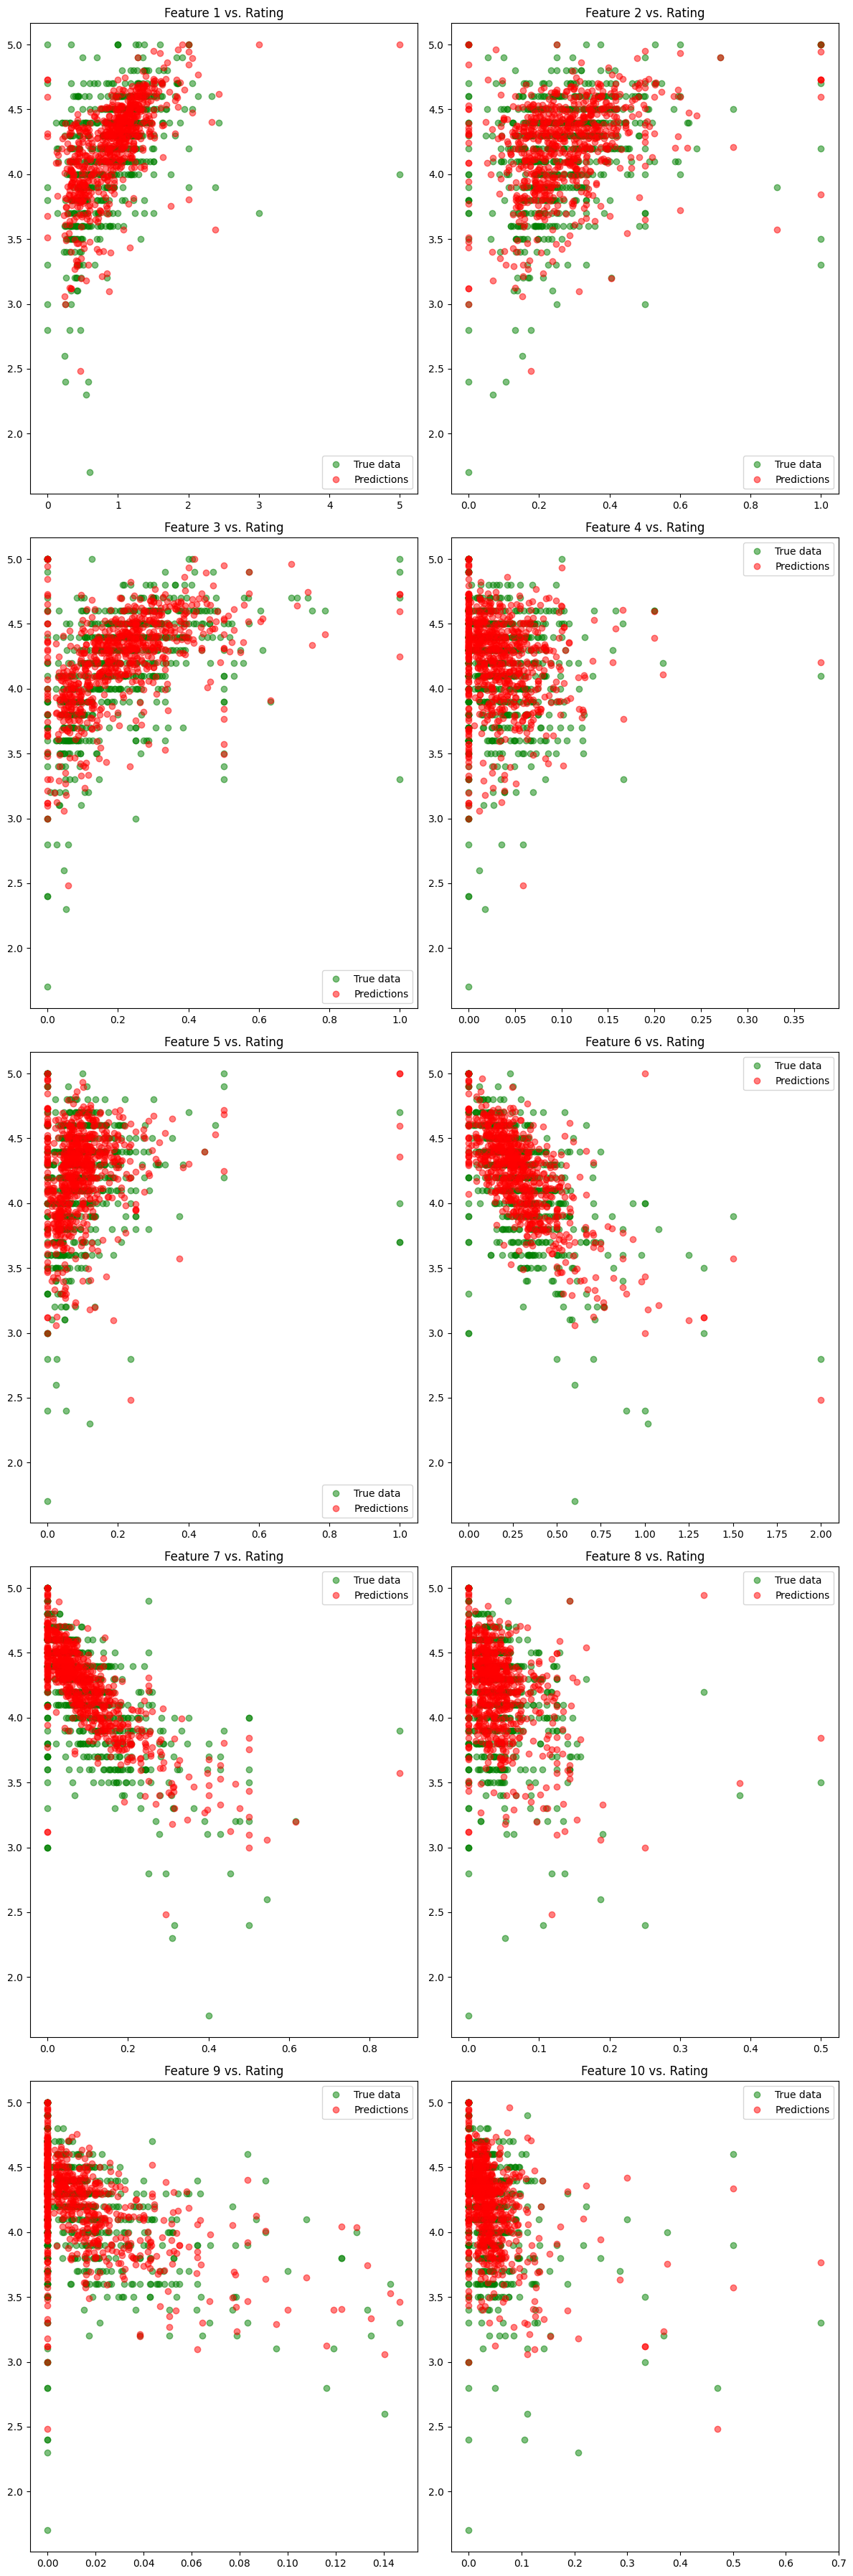

In [776]:
all_predictions, all_labels, all_inputs = test_model(model, test_loader)

plt.clf()
fig, axes = plt.subplots(5, 2, figsize=(12, 36))
axes = axes.flatten()

# Plot model predictions with respect to each attribute
for i in range(10):  # Assuming 10 features
    axes[i].plot(all_inputs[:, i], all_labels, 'go', label='True data', alpha=0.5)
    axes[i].plot(all_inputs[:, i], all_predictions, 'ro', label='Predictions', alpha=0.5)
    axes[i].set_title(f'Feature {i+1} vs. Rating')
    axes[i].legend(loc='best')

plt.tight_layout()
plt.show()

perform some performance calculations

Mean Squared Error: 0.05958239361643791
Root Mean Squared Error: 0.2440950572490692
R-squared: 0.6623541291986287


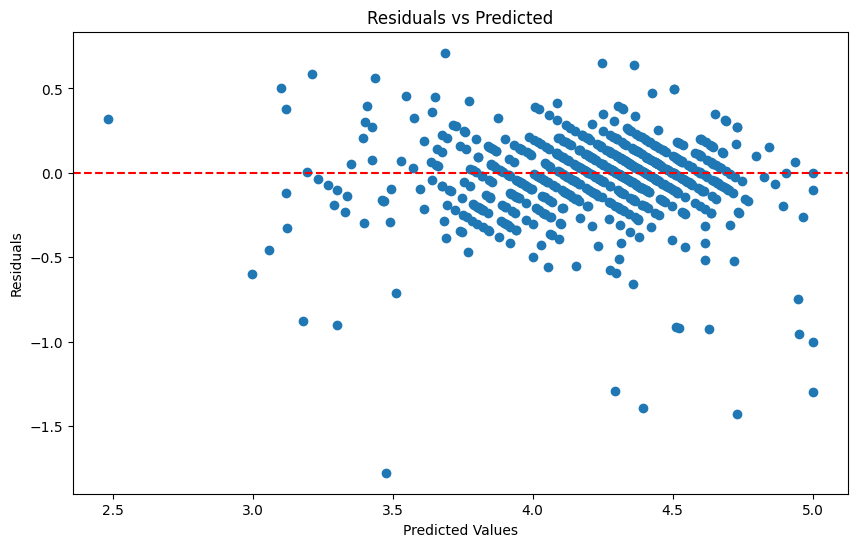

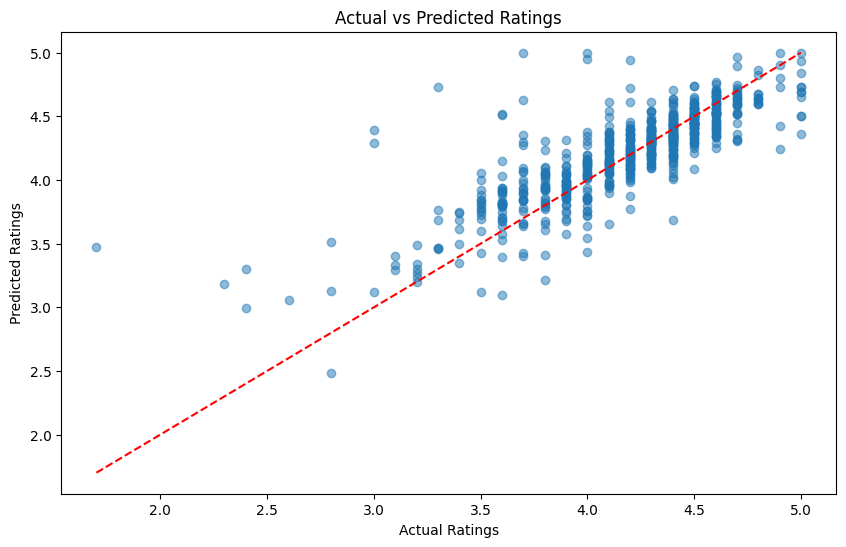

In [777]:
# Calculate metrics
mse = mean_squared_error(all_labels, all_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(all_labels, all_predictions)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

# Residual Plot
plt.figure(figsize=(10, 6))
residuals = all_labels - all_predictions
plt.scatter(all_predictions, residuals)
plt.title('Residuals vs Predicted')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# Comparison Plot
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_predictions, alpha=0.5)
plt.title('Actual vs Predicted Ratings')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], 'r--')  # line representing perfect predictions
plt.show()

plot the mse over multiple epochs

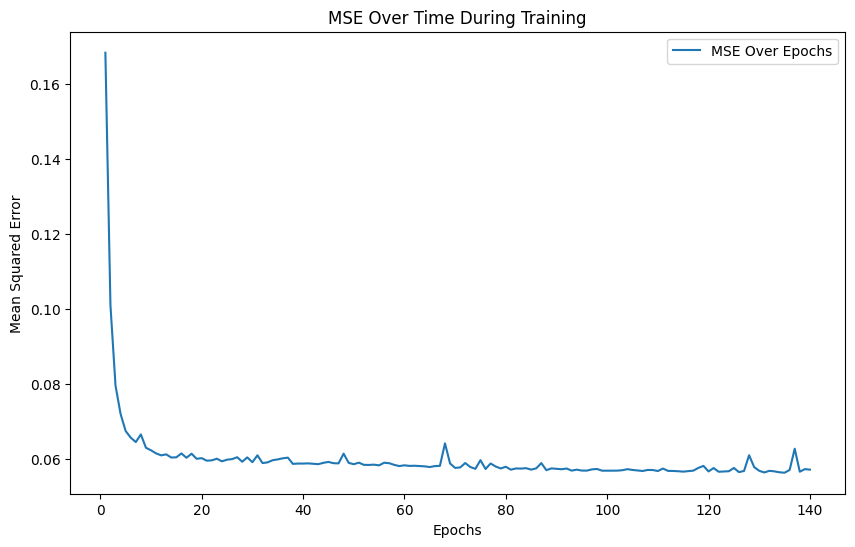

In [778]:
# Plotting the MSE over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), mse_history, label='MSE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('MSE Over Time During Training')
plt.legend()
plt.show()

get the weights

In [779]:
# Extracting weights and biases from each layer
for name, param in model.named_parameters():
    if 'weight' in name:
        print(f'{name}: {param.data.cpu().numpy().flatten()}')
    elif 'bias' in name:
        print(f'{name}: {param.data.cpu().numpy()}')


layer1.weight: [ 0.06708548  0.33421516 -0.15986443  0.05426558  0.11980806 -0.23198368
  0.30401605 -0.12479984  0.2986372  -0.08262798 -0.04497458 -0.11573755
 -0.04614652  0.04451043 -0.11249503 -0.30199578 -0.62527853 -0.20989622
 -0.24675097  0.28774714 -0.01109342  0.03190428 -0.00389393  0.19497904
  0.04920013 -0.31293988  0.07578406  0.18903719 -0.256576   -0.29241255
  0.15960997  0.24423444  0.19414261 -0.04667794  0.1210493  -0.26538336
 -0.29384956 -0.02299984 -0.27993658 -0.26558098  0.16668785 -0.30722865
  0.13208121  0.0190688   0.22060719  0.20826535  0.2237475   0.3061608
 -0.22460766 -0.09491614 -0.12164295  0.24502528 -0.03773042 -0.30038208
  0.07429795 -0.02851227 -0.13740815 -0.06780469 -0.3941133  -0.19117409
 -0.1936185   0.05132363 -0.15171643  0.25415698  0.12646024 -0.14864568
 -0.2261014  -0.28838813  0.18201208 -0.14945775 -0.11780195  0.19311202
 -0.27525848 -0.2239133   0.23947224 -0.23287484 -0.28355184  0.09518144
  0.15369377 -0.28873754  0.28627884 